In [1]:
from sympy import *
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import os
import pandas as pd
import fenics as fe

In [2]:
# Test Parameter
ConstitutiveModels = ['NeoHookean', 'MooneyRivlin', 'Gent', 'Demiray', 'Ogden']
ConstitutiveModel  = ConstitutiveModels[4]   # Constitutive model used for comparison
URange = [0.9, 1.5]                          # Stretch ratio interval
Delta  =  0.01                               # Step size

# Material Parameters
NuV    = 0.5    # Poisson's ratio (-)
MuV    = 0.66   # Shear modulus (kpa)
C01V   = 0.00   # Mooney-Rivlin 3rd material constant (kPa) if == 0 => Neo-Hookean
JmV    = 0.08   # Gent 3rd material constant (-) if == 1 => ~Neo-Hookean with ln
BetaV  = 20.3   # Demiray 3rd material constant (-) if == 1 => ~Neo-Hookean with exp
AlphaV = -24.3  # Ogden 3rd material constant (-) if == 2 => Neo-Hookean

# Folder for the results
Output_Path = os.path.join('IncompressibleComparisonResults')
os.makedirs(Output_Path, exist_ok=True)

In [3]:
# Analytical Solution

# Identity tensor
I = eye(3)

# Direction vectors
e1 = I[:,0]
e2 = I[:,1]
e3 = I[:,2]

# Dilatation coefficients
u, Nu, Mu   = symbols(r'u \nu \mu', positive=True)
LambdaH = 1             # Coefficient for homogeneous dilatation
LambdaX = u **(-Nu)     # Coefficient for lengthening in e1 direction (here <1)
LambdaY = u **(-Nu)     # Coefficient for lengthening in e2 direction (here <1)
LambdaZ = u             # Coefficient for lengthening in e3 direction (here >1)

# Deformation matrices
U = I + (LambdaX-1) * np.outer(e1,e1) + (LambdaY-1) * np.outer(e2,e2) + (LambdaZ-1) * np.outer(e3,e3)

# Gradient of the deformation
F = (LambdaH-1) * I + U

# Volume change
J = det(F)

# Right Cauchy-Green strain tensor
C = transpose(F) * F

# Eigenvalues of Right Cauchy-Green strain tensor
Lambda1, Lambda2, Lambda3 = symbols(r'\lambda_1 \lambda_2 \lambda_3')

# Invariants
J, I1, I2 = symbols(r'J I_1 I_2')
JFunction = Lambda1*Lambda2*Lambda3
I1Function = Lambda1**2+Lambda2**2+Lambda3**2
I2Function = Lambda1**2*Lambda2**2 + Lambda2**2*Lambda3**2 + Lambda3**2*Lambda1**2

# Hyperelastic models (incompressible)
if ConstitutiveModel == ConstitutiveModels[0]:     # Neo-Hookean
    C1           = symbols(r'C_1', positive=True)
    C1Function   = Mu / 2
    Psi          = C1 * (I1 - 3)
    
elif ConstitutiveModel == ConstitutiveModels[1]:   # Mooney-Rivlin
    C01, C10, D1 = symbols(r'C_{01} C_{10} D_{1}', positive=True)
    C10Function  = Mu / 2 - C01
    D1Function   = Mu * (1+Nu) / (3*(1-2*Nu))
    Psi          = C01 * (J**Rational(-4,3)*I2 - 3) + C10 * (J**Rational(-2,3)*I1 - 3)

elif ConstitutiveModel == ConstitutiveModels[2]:   # Gent
    Jm           = symbols('J_m')
    Psi          = - Mu*Jm/2 * ln(1 - (I1 - 3) / Jm)

elif ConstitutiveModel == ConstitutiveModels[3]:   # Demiray
    Beta         = symbols(r'\beta')
    Psi          = Mu/2 * (exp(Beta*(I1 - 3)) - 1) / Beta

elif ConstitutiveModel == ConstitutiveModels[4]:   # Ogden
    Alpha        = symbols(r'\alpha')
    Psi          = 2*Mu * (Lambda1**Alpha + Lambda2**Alpha + Lambda3**Alpha - 3) / Alpha**2
    
# Derivative with respect to Lambdas (https://en.wikipedia.org/wiki/Hyperelastic_material: compressible isotropic hyperelastic material)
PsiLambda = Psi.subs({J:JFunction,I1:I1Function,I2:I2Function})

T1 = Lambda1*Derivative(PsiLambda, Lambda1)
T1 = T1.doit()

T2 = Lambda2*Derivative(PsiLambda, Lambda2)
T2 = T2.doit()

T3 = Lambda3*Derivative(PsiLambda, Lambda3)
T3 = T3.doit()

T = T1 * np.outer(e1,e1) + T2 *np.outer(e2,e2) + T3 * np.outer(e3,e3)
T = Matrix(T).doit()
T = T.subs({JFunction:J,I1Function:I1,I2Function:I2})
T = simplify(T)
T = T.subs({JFunction:J,I1Function:I1,I2Function:I2})
T = T.subs({J:'J',I1:'I_1',I2:'I_2'})

# Replace invariants
T = T.subs({'J':JFunction,'I_1':I1Function,'I_2':I2Function})

# Replace material constants
if ConstitutiveModel == ConstitutiveModels[0]:       # Neo-Hookean
    T = T.subs({C1:C1Function})
elif ConstitutiveModel == ConstitutiveModels[1]:     # Mooney-Rivlin
    T = T.subs({C10:C10Function})

# Replace eingenvalues
Lambdas = C.eigenvals()
Lambdas = list(Lambdas)
T = T.subs({Lambda1:sqrt(Lambdas[0]), Lambda2:sqrt(Lambdas[0]), Lambda3:sqrt(Lambdas[1])})

# T11 and T22 are null
T = T - T[0,0] * I
T = simplify(T)

# Other stresses
J = det(F)                                    # Volume change
P = J * T * F.inv().transpose()               # Nominal stress
S = J * F.inv() * T * F.inv().transpose()     # Material stress

# Compute axial stress
U33 = np.linspace(URange[0],URange[1],int((URange[1]-URange[0])/Delta+1))
if ConstitutiveModel == ConstitutiveModels[0]:                            # Neo-Hookean
    AnalyticalFunction = lambdify((Nu, Mu, u), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(NuV, MuV, U33)
    
elif ConstitutiveModel == ConstitutiveModels[1]:                          # Mooney-Rivlin
    AnalyticalFunction = lambdify((C01, Nu, Mu, u), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(C01V, NuV, MuV, U33)
    
elif ConstitutiveModel == ConstitutiveModels[2]:                          # Gent
    AnalyticalFunction = lambdify((Jm, Nu, Mu, u), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(JmV, NuV, MuV, U33)
    
elif ConstitutiveModel == ConstitutiveModels[3]:                          # Demiray
    AnalyticalFunction = lambdify((Beta, Nu, Mu, u), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(BetaV, NuV, MuV, U33)
    
elif ConstitutiveModel == ConstitutiveModels[4]:                          # Ogden
    AnalyticalFunction = lambdify((Alpha, Nu, Mu, u), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(AlphaV, NuV, MuV, U33)

# Save values to table
DataFrame = pd.DataFrame({'Stretch Ratio (-)':U33, 'Analytical Stress (kPa)':AnalyticalStress})

In [4]:
# Finite Element Solution

# Discretization (number of elements by sides)
Nelements = 2

# Geometry (mm)
Length, Thickness, Height = [5, 5, 5]

# Mesh
Mesh = fe.BoxMesh(fe.Point(-Length/2, -Thickness/2, -Height/2), fe.Point( Length/2, Thickness/2, Height/2), Nelements, Nelements, Nelements)

# Discretization type
Type = 'Lagrange'
PolDegree = 1

# Functions spaces
V_ele = fe.VectorElement(Type, Mesh.ufl_cell(), PolDegree+1)
V     = fe.VectorFunctionSpace(Mesh, Type, PolDegree)

W_ele = fe.FiniteElement(Type, Mesh.ufl_cell(), PolDegree)
W     = fe.FunctionSpace(Mesh, Type, PolDegree)

Y_ele = fe.MixedElement([V_ele, W_ele])
Y     = fe.FunctionSpace(Mesh,Y_ele)

# Finite element functions
dup   = fe.TrialFunction(Y)
vq    = fe.TestFunction(Y)
up    = fe.Function(Y)

u, p  = fe.split(up)

# Kinematics
d = u.geometric_dimension()
I = fe.Identity(d)                    # Identity tensor
F = I + fe.grad(u)                    # Deformation gradient
F = fe.variable(F)                    # To differentiate Psi(F)
C = F.T*F                             # Right Cauchy-Green deformation tensor

# Invariants
J = fe.det(F)                         # Jacobian of F
Ic = fe.tr(C)                         # Trace of C

def I1(C):
    return fe.tr(C)

def I2(C):
    c1 = C[0,0]*C[1,1] + C[0,0]*C[2,2] + C[1,1]*C[2,2]
    c2 = C[0,1]*C[0,1] + C[0,2]*C[0,2] + C[1,2]*C[1,2]
    return c1 - c2

def I3(C):
    return fe.det(C)

# Define function necessary for eigenvalues computation
def v_inv(C):
    return (I1(C)/3.)**2 - I2(C)/3.

def s_inv(C):
    return (I1(C)/3.)**3 - I1(C)*I2(C)/6. + I3(C)/2.

def phi_inv(C):
    arg = s_inv(C)/v_inv(C)*fe.sqrt(1./v_inv(C))
    # numerical issues if arg~0
    # https://fenicsproject.org/qa/12299
    # /nan-values-when-computing-arccos-1-0-bug/
    arg_cond = fe.conditional( fe.ge(arg, 1-fe.DOLFIN_EPS),
    1-fe.DOLFIN_EPS,fe.conditional( fe.le(arg, -1+fe.DOLFIN_EPS),
    -1+fe.DOLFIN_EPS, arg ))
    return fe.acos(arg_cond)/3.

# Eigenvalues of the strech tensor C
lambda_1 = Ic/3. + 2*fe.sqrt(v_inv(C))*fe.cos(phi_inv(C))
lambda_2 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. + phi_inv(C))
lambda_3 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. - phi_inv(C))

# Hyperelastic models (incompressible)
if ConstitutiveModel == ConstitutiveModels[0]:     # Neo-Hookean
    FileName = 'NeoHookean_Nu' + str(NuV) + 'Mu' + str(MuV)
    Psi = (MuV/2)*(I1(C) - 3) - p*fe.ln(J)
    
elif ConstitutiveModel == ConstitutiveModels[1]:   # Mooney-Rivlin
    FileName = 'MooneyRivlin_Nu' + str(NuV) + 'Mu' + str(MuV) + 'C01' + str(C01V)
    Psi = C01V * (J**(-4/3)*I2(C) - 3) + (MuV / 2 - C01V) * (J**(-2/3)*I1(C) - 3) - p*fe.ln(J)

elif ConstitutiveModel == ConstitutiveModels[2]:   # Gent
    FileName = 'Gent_Nu' + str(NuV) + 'Mu' + str(MuV) + 'Jm' + str(JmV)
    Psi = - MuV*JmV/2 * fe.ln(1 - (I1(C) - 3) / JmV) - p*fe.ln(J)

elif ConstitutiveModel == ConstitutiveModels[3]:   # Demiray
    FileName = 'Demiray_Nu' + str(NuV) + 'Mu' + str(MuV) + 'Beta' + str(BetaV)
    Psi = MuV/2 * (fe.exp(BetaV*(I1(C) - 3)) - 1) / BetaV - p*fe.ln(J)

elif ConstitutiveModel == ConstitutiveModels[4]:   # Ogden
    FileName = 'Ogden_Nu' + str(NuV) + 'Mu' + str(MuV) + 'Alpha' + str(AlphaV)
    PSiEstimate = Psi = (MuV/2)*(I1(C) - 3) - p*fe.ln(J)
    Psi = 2 * MuV * (lambda_1**(AlphaV/2.) + lambda_2**(AlphaV/2.) + lambda_3**(AlphaV/2.) - 3) / AlphaV**2 - p*fe.ln(J)

# Subdomains definition
class LowerSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], -Height/2, tol)
    
class UpperSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], Height/2, tol)
    
# Define integration over subdomains
Domains_Facets = fe.MeshFunction('size_t', Mesh, Mesh.geometric_dimension()-1)
ds = fe.Measure('ds', domain=Mesh, subdomain_data=Domains_Facets)

# Mark all domain facets with 0
Domains_Facets.set_all(0)

# Mark bottom facets with 1
bottom = LowerSide()
bottom.mark(Domains_Facets, 1)

# Mark upper facets with 2
upper = UpperSide()
upper.mark(Domains_Facets, 2)

# Boundary conditions
u_0 = fe.Constant((0))          # No displacement
u_1 = fe.Expression(('(s-1)*h'), degree=1, s = URange[0], h = Height )
Dir = fe.Constant((0,0,1))            # Deformation direction

# Normal to moving side
n = fe.Constant((0, 0, 1))
    
# Apply boundary conditions
bcl = fe.DirichletBC(Y.sub(0).sub(2), u_0, Domains_Facets, 1)
bcu = fe.DirichletBC(Y.sub(0).sub(2), u_1, Domains_Facets, 2)

# Set of boundary conditions
bcs = [bcl, bcu]

if ConstitutiveModel == ConstitutiveModels[4]:   # Ogden need estimation

    # Total potential energy
    Pi = PSiEstimate * fe.dx
    
    # First directional derivative of the potential energy
    Fpi = fe.derivative(Pi,up,vq)

    # Jacobian of Fpi
    Jac = fe.derivative(Fpi,up,dup)

    # Define option for the compiler (optional)
    ffc_options = {"optimize": True, \
                   "eliminate_zeros": True, \
                   "precompute_basis_const": True, \
                   "precompute_ip_const": True, \
                   "quadrature_degree": 2, \
                   "representation" : "uflacs" }

    # Define the problem
    problem = fe.NonlinearVariationalProblem(Fpi, up, bcs, Jac, form_compiler_parameters=ffc_options)

    # Define the solver
    solver = fe.NonlinearVariationalSolver(problem)

    # Set solver parameters (optional)
    prm = solver.parameters
    prm['newton_solver']['linear_solver'] = 'mumps'
    fe.parameters["form_compiler"]["representation"] = "uflacs"
    fe.parameters["form_compiler"]["quadrature_degree"] = 2
    
    # Set initial displacement
    u_1.s = URange[0]
    
    # Compute solution and save displacement
    solver.solve()

# Total potential energy
Pi = Psi * fe.dx

# First directional derivative of the potential energy
Fpi = fe.derivative(Pi,up,vq)

# Jacobian of Fpi
Jac = fe.derivative(Fpi,up,dup)

# Define option for the compiler (optional)
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True, \
               "quadrature_degree": 2, \
               "representation" : "uflacs" }

# Define the problem
problem = fe.NonlinearVariationalProblem(Fpi, up, bcs, Jac, form_compiler_parameters=ffc_options)

# Define the solver
solver = fe.NonlinearVariationalSolver(problem)

# Set solver parameters (optional)
prm = solver.parameters
prm['newton_solver']['linear_solver'] = 'mumps'
fe.parameters["form_compiler"]["representation"] = "uflacs"
fe.parameters["form_compiler"]["quadrature_degree"] = 2

# Results File
results = xdmffile = fe.XDMFFile(os.path.join(Output_Path, FileName + '.xdmf'))
results.parameters['flush_output'] = True
results.parameters['functions_share_mesh'] = True

# Data frame to store values
DataFrameFE = pd.DataFrame()

# Set the stretch state to initial state
StretchState = URange[0]

for Step in range(int((URange[1]-URange[0])/Delta+1)):
    
    # Update current state
    u_1.s = StretchState
    
    # Compute solution and save displacement
    solver.solve()
    u, p = fe.split(up)
    
    # First Piola Kirchoff (nominal) stress
    P = fe.diff(Psi, F)
    
    # Nominal stress vectors normal to upper surface
    p = fe.dot(P,n)
    
    # Reaction force on the upper surface
    f = fe.assemble(fe.inner(p,Dir)*ds(2))
    
    # Mean nominal stress on the upper surface
    Pm = f/fe.assemble(1*ds(2))
    
    # Project the displacement onto the vector function space
    u_project = fe.project(u, V, solver_type='cg')
    u_project.rename('displacement (mm)', '')
    results.write(u_project,Step)
    
    # Save values to table
    DataFrameFE = DataFrameFE.append({'FE Stress (kPa)':Pm}, ignore_index=True)

    # Update the stretch state
    StretchState += Delta
    
    if ConstitutiveModel == ConstitutiveModels[4] and StretchState == 1:   # Ogden
        DataFrameFE = DataFrameFE.append({'FE Stress (kPa)':np.nan}, ignore_index=True)
        StretchState += Delta
    
# Join dataframe
DataFrame = DataFrame.join(DataFrameFE)
# Save dataframe
DataFrame.to_csv(os.path.join(Output_Path, FileName + '.csv'), index=False)

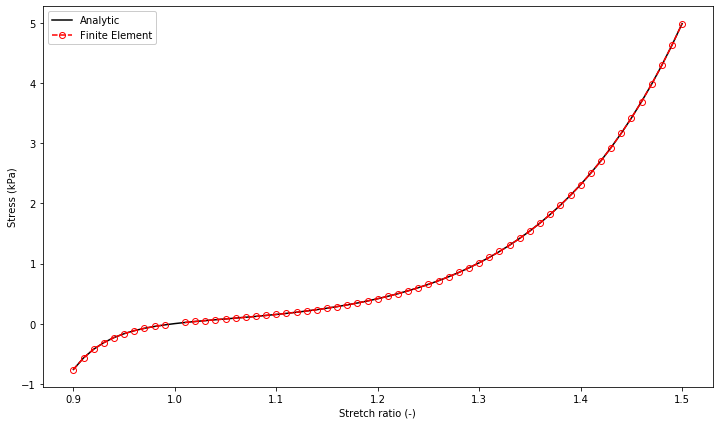

In [5]:
# Plot Results
plt.figure(figsize=(12,7))
ax = plt.subplot(1, 1, 1)
DataFrame.plot(x='Stretch Ratio (-)', y='Analytical Stress (kPa)', ax=ax, color = 'black', linestyle = '-', label='Analytic')
DataFrame.plot(x='Stretch Ratio (-)', y='FE Stress (kPa)', ax=ax, color = 'red', linestyle = '--', marker='o', fillstyle='none', label='Finite Element')
ax.set_xlabel('Stretch ratio (-)')
ax.set_ylabel('Stress (kPa)')
plt.legend(loc='upper left', frameon=True, framealpha=1)
plt.savefig(os.path.join(Output_Path, FileName + '.pdf'))
plt.show()